# Predictive modeling of customer bookings
## EDA (Exploratory Data Analysis)
First, we must explore the data in order to better understand what we have and the statistical properties of the dataset.

In [1]:
import pandas as pd
import numpy as np

In [2]:
df = pd.read_csv("customer_booking.csv", encoding="ISO-8859-1")
df.head()

,num_passengers,sales_channel,trip_type,purchase_lead,length_of_stay,flight_hour,flight_day,route,booking_origin,wants_extra_baggage,wants_preferred_seat,wants_in_flight_meals,flight_duration,booking_complete
0,2,Internet,RoundTrip,262,19,7,Sat,AKLDEL,New Zealand,1,0,0,5.52,0
1,1,Internet,RoundTrip,112,20,3,Sat,AKLDEL,New Zealand,0,0,0,5.52,0
2,2,Internet,RoundTrip,243,22,17,Wed,AKLDEL,India,1,1,0,5.52,0
3,1,Internet,RoundTrip,96,31,4,Sat,AKLDEL,New Zealand,0,0,1,5.52,0
4,2,Internet,RoundTrip,68,22,15,Wed,AKLDEL,India,1,0,1,5.52,0


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 14 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   num_passengers         50000 non-null  int64  
 1   sales_channel          50000 non-null  object 
 2   trip_type              50000 non-null  object 
 3   purchase_lead          50000 non-null  int64  
 4   length_of_stay         50000 non-null  int64  
 5   flight_hour            50000 non-null  int64  
 6   flight_day             50000 non-null  object 
 7   route                  50000 non-null  object 
 8   booking_origin         50000 non-null  object 
 9   wants_extra_baggage    50000 non-null  int64  
 10  wants_preferred_seat   50000 non-null  int64  
 11  wants_in_flight_meals  50000 non-null  int64  
 12  flight_duration        50000 non-null  float64
 13  booking_complete       50000 non-null  int64  
dtypes: float64(1), int64(8), object(5)
memory usage: 5.3+ 

Fortunately, we have no null values.

It looks like some of these columns should be converted into different data types, e.g. flight_day.

To provide more context, below is a more detailed data description, explaining exactly what each column means:
- `num_passengers` = number of passengers travelling
- `sales_channel` = sales channel booking was made on
- `trip_type` = trip Type (Round Trip, One Way, Circle Trip)
- `purchase_lead` = number of days between travel date and booking date
- `length_of_stay` = number of days spent at destination
- `flight_hour` = hour of flight departure
- `flight_day` = day of week of flight departure
- `route` = origin -> destination flight route
- `booking_origin` = country from where booking was made
- `wants_extra_baggage` = if the customer wanted extra baggage in the booking
- `wants_preferred_seat` = if the customer wanted a preferred seat in the booking
- `wants_in_flight_meals` = if the customer wanted in-flight meals in the booking
- `flight_duration` = total duration of flight (in hours)
- `booking_complete` = flag indicating if the customer completed the booking

Before we compute any statistics on the data, lets do any necessary data conversion

In [4]:
df['flight_day'].unique()

array(['Sat', 'Wed', 'Thu', 'Mon', 'Sun', 'Tue', 'Fri'], dtype=object)

In [5]:
mapping = {
    'Mon':1,
    'Tue':2,
    'Wed':3,
    'Thu':4,
    'Fri':5, 
    'Sat':6,
    'Sun':7
}
df['flight_day'] = df['flight_day'].map(mapping)

In [6]:
df['flight_day'].unique()

array([6, 3, 4, 1, 7, 2, 5], dtype=int64)

In [7]:
#drop unnecessary column
df = df.drop(columns=['route'])

Let's take a quick overview of a few things such as the mean, min, max and overall distribution of each column.

In [8]:
df.describe()

,num_passengers,purchase_lead,length_of_stay,flight_hour,flight_day,wants_extra_baggage,wants_preferred_seat,wants_in_flight_meals,flight_duration,booking_complete
count,50000.000000,50000.000000,50000.00000,50000.00000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000
mean,1.591240,84.940480,23.04456,9.06634,3.814420,0.668780,0.296960,0.427140,7.277561,0.149560
std,1.020165,90.451378,33.88767,5.41266,1.992792,0.470657,0.456923,0.494668,1.496863,0.356643
min,1.000000,0.000000,0.00000,0.00000,1.000000,0.000000,0.000000,0.000000,4.670000,0.000000
25%,1.000000,21.000000,5.00000,5.00000,2.000000,0.000000,0.000000,0.000000,5.620000,0.000000
50%,1.000000,51.000000,17.00000,9.00000,4.000000,1.000000,0.000000,0.000000,7.570000,0.000000
75%,2.000000,115.000000,28.00000,13.00000,5.000000,1.000000,1.000000,1.000000,8.830000,0.000000
max,9.000000,867.000000,778.00000,23.00000,7.000000,1.000000,1.000000,1.000000,9.500000,1.000000


There we can see that the target attribute is imbalanced; there are less complete bookings (only 15% of all instances)

In [9]:
df.booking_complete.value_counts() / 50000

0    0.85044
1    0.14956
Name: booking_complete, dtype: float64

In [10]:
df.shape

(50000, 13)

## Prepare the data and Train the Model

In [11]:
df.columns

Index(['num_passengers', 'sales_channel', 'trip_type', 'purchase_lead',
       'length_of_stay', 'flight_hour', 'flight_day', 'booking_origin',
       'wants_extra_baggage', 'wants_preferred_seat', 'wants_in_flight_meals',
       'flight_duration', 'booking_complete'],
      dtype='object')

In [12]:
num_attribs = ['num_passengers', 'purchase_lead', 'length_of_stay', 'flight_hour', 'flight_day', 'flight_duration']
cat_attribs = ['sales_channel', 'trip_type', 'booking_origin']

In [13]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import StandardScaler

full_pipeline = ColumnTransformer([
    ("num", StandardScaler(), num_attribs),
    ("cat", OrdinalEncoder(), cat_attribs)
], remainder='passthrough')

full_pipeline.fit(df.iloc[:, :-1])

ColumnTransformer(remainder='passthrough',
                  transformers=[('num', StandardScaler(),
                                 ['num_passengers', 'purchase_lead',
                                  'length_of_stay', 'flight_hour', 'flight_day',
                                  'flight_duration']),
                                ('cat', OrdinalEncoder(),
                                 ['sales_channel', 'trip_type',
                                  'booking_origin'])])

In [14]:
X = df.iloc[:,:-1]
y = df.iloc[:, -1]

In [15]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 42, shuffle=True, stratify = y)

In [16]:
X_train_prep = full_pipeline.transform(X_train)
X_test_prep = full_pipeline.transform(X_test)

In [17]:
from sklearn.ensemble import RandomForestClassifier
rforest_clf = RandomForestClassifier(class_weight='balanced')
rforest_clf.fit(X_train_prep, y_train)

RandomForestClassifier(class_weight='balanced')

This model (Random Forest) was our choice because it takes care of multicollinearity as well as our data being imbalanced. It does run the risk of overfitting the data, but it is worth the try.

## Assessing and Improving the Model

In [18]:
y_train_predicted = rforest_clf.predict(X_train_prep)
y_test_predicted = rforest_clf.predict(X_test_prep)

In [19]:
from sklearn.metrics import plot_confusion_matrix, accuracy_score, roc_auc_score

rf_train_score = roc_auc_score(y_train, y_train_predicted)
rf_test_score = roc_auc_score(y_test, y_test_predicted)

print(f'roc_auc_score on the train data: {rf_train_score}')
print(f'roc_auc_score on the test data: {rf_test_score}')

roc_auc_score on the train data: 0.999479192865012
roc_auc_score on the test data: 0.5381792651209119


The next step would be to find parameters that will help the model perform better. We can do this by using grid search.

In [20]:
from sklearn.model_selection import GridSearchCV

grid_params = {'n_estimators': [5, 10, 50, 100, 200], 
              'class_weight': ['balanced'], 
              'criterion': ['gini', 'entropy'], 
              'max_depth': [2,4,6,10] 
              } 

grid_search = GridSearchCV(rforest_clf, grid_params, cv=3, scoring= 'roc_auc')

grid_search.fit(X_train_prep, y_train)

GridSearchCV(cv=3, estimator=RandomForestClassifier(class_weight='balanced'),
             param_grid={'class_weight': ['balanced'],
                         'criterion': ['gini', 'entropy'],
                         'max_depth': [2, 4, 6, 10],
                         'n_estimators': [5, 10, 50, 100, 200]},
             scoring='roc_auc')

In [21]:
grid_search.best_params_

{'class_weight': 'balanced',
 'criterion': 'entropy',
 'max_depth': 10,
 'n_estimators': 100}

In [22]:
best_rforest_clf = grid_search.best_estimator_

best_rforest_clf.fit(X_train_prep, y_train)

y_train_pred_best = best_rforest_clf.predict(X_train_prep)
y_test_pred_best = best_rforest_clf.predict(X_test_prep)

rf_train_score_best = roc_auc_score(y_train, y_train_pred_best)
rf_test_score_best = roc_auc_score(y_test, y_test_pred_best)

print(f'roc_auc_score on the train data: {rf_train_score_best}')
print(f'roc_auc_score on the test data: {rf_test_score_best}')

roc_auc_score on the train data: 0.7513724173677282
roc_auc_score on the test data: 0.6991808824787077


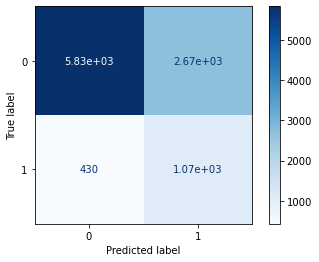

In [23]:
# plot a confusion matrix
import matplotlib.pyplot as plt
plot_confusion_matrix(best_rforest_clf, X_test_prep, y_test, cmap=plt.cm.Blues, values_format='.3g')
plt.grid(False)

In [24]:
acc_score_best = accuracy_score(y_test, y_test_pred_best)
print(f'Accuracy score on the test data is {acc_score_best}')

Accuracy score on the test data is 0.6898


## Gradient Boost / AdaBoost
We will continue our model search by using gradient boost. Our aim is to see if we can raise our ROC_AUC and Accuracy scores using the ensamble methods gradient boost & AdaBoost.

In [25]:
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier

adaboost_clf = AdaBoostClassifier(random_state = 42)
gradboost_clf = GradientBoostingClassifier(random_state = 42)

adaboost_clf.fit(X_train_prep, y_train)
gradboost_clf.fit(X_train_prep, y_train)

GradientBoostingClassifier(random_state=42)

In [26]:
# making predictions
adaboost_train_preds = adaboost_clf.predict(X_train_prep)
adaboost_test_preds = adaboost_clf.predict(X_test_prep)

gradboost_train_preds = gradboost_clf.predict(X_train_prep)
gradboost_test_preds = gradboost_clf.predict(X_test_prep)

In [27]:
# display results 
def display_accuracy_and_roc_auc_score(actual, preds, model_name):
    acc = accuracy_score(actual, preds)
    roc_auc = roc_auc_score(actual, preds)
    print(f"Model: {model_name}")
    print(f"Accuracy score: {acc}")
    print(f"ROC-AUC score: {roc_auc}")
print("Training Metrics:")
display_accuracy_and_roc_auc_score(y_train, adaboost_train_preds, "AdaBoost")
print("")
display_accuracy_and_roc_auc_score(y_train, gradboost_train_preds, "GradBoost")
print("")
print("Testing Metrics:")
display_accuracy_and_roc_auc_score(y_test, adaboost_test_preds, "AdaBoost")
print("")
display_accuracy_and_roc_auc_score(y_test, gradboost_test_preds, "GradBoost")

Training Metrics:
Model: AdaBoost
Accuracy score: 0.85015
ROC-AUC score: 0.5095365466143861

Model: GradBoost
Accuracy score: 0.851325
ROC-AUC score: 0.5109851031920698

Testing Metrics:
Model: AdaBoost
Accuracy score: 0.8507
ROC-AUC score: 0.5100918221560411

Model: GradBoost
Accuracy score: 0.8506
ROC-AUC score: 0.5078295963899971


As we can see, no matter what method we use, our model is bad. 

# Conclusion
Below you can see how each model did on the test/predicted data with encoding applied.
## Random Forest 
- ROC-AUC score: 0.6192329653597259
- Accuracy score: 0.6342
## Gradient Boost 
- ROC-AUC score: 0.4999413145539906
- Accuracy score: 0.8519
## AdaBoost 
- ROC-AUC score: 0.5
- Accuracy score: 0.852

In [28]:
print('Model: Random Forest')
print(f'ROC-AUC score: {rf_test_score_best}')
print(f'Accuracy score: {acc_score_best}')
print("")
display_accuracy_and_roc_auc_score(y_test, adaboost_test_preds, "AdaBoost")
print("")
display_accuracy_and_roc_auc_score(y_test, gradboost_test_preds, 'Gradboost')


Model: Random Forest
ROC-AUC score: 0.6991808824787077
Accuracy score: 0.6898

Model: AdaBoost
Accuracy score: 0.8507
ROC-AUC score: 0.5100918221560411

Model: Gradboost
Accuracy score: 0.8506
ROC-AUC score: 0.5078295963899971


From the list below you can see that the best performing model was Random Forest. Why? When you look at both the roc_auc and accuracy score for random forest, you can see that there is not that much of a spread between the two. This is showing that the overfitting is not present enough to where how correctly the model predicts is impacted.

# Perfomance Measures Using Cross-Validation

In [29]:
from sklearn.model_selection import cross_val_predict

y_test_pred = cross_val_predict(best_rforest_clf, X_test_prep, y_test, cv=3)

In [30]:
from sklearn.metrics import confusion_matrix
cf_matrix = confusion_matrix(y_test, y_test_pred)
cf_matrix

array([[6859, 1645],
       [ 719,  777]], dtype=int64)

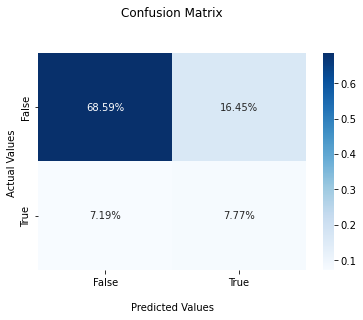

In [31]:
import seaborn as sns

ax = sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, 
            fmt='.2%', cmap='Blues')

ax.set_title('Confusion Matrix\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])

plt.show()

In [32]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

           0       0.91      0.81      0.85      8504
           1       0.32      0.52      0.40      1496

    accuracy                           0.76     10000
   macro avg       0.61      0.66      0.62     10000
weighted avg       0.82      0.76      0.78     10000



<Figure size 900x600 with 0 Axes>

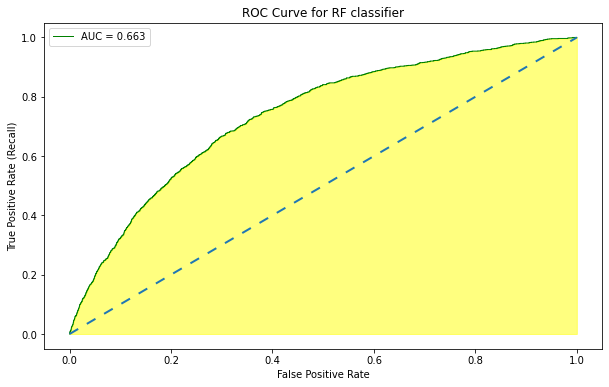

In [33]:
from sklearn.metrics import roc_curve

# get the probability distribution
probas = cross_val_predict(best_rforest_clf, X_test_prep, y_test, cv=3, method='predict_proba')[:, 1]

# FPR, TPR and thresholds
fpr, tpr, thresholds = roc_curve(y_test, probas)

# get the ROC-AUC score
roc_auc = roc_auc_score(y_test, y_test_pred)

plt.figure(dpi=150)
plt.figure(figsize=[10,6])
plt.plot(fpr, tpr, lw=1, color='green', label=f'AUC = {roc_auc:.3f}')
plt.fill_between(fpr, tpr, alpha=.5, color='yellow')
plt.title('ROC Curve for RF classifier')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate (Recall)')
# Add dashed line with a slope of 1
plt.plot([0,1], [0,1], linestyle=(0, (5, 5)), linewidth=2)
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.legend()
plt.show()

## Identify Important Features

In [34]:
feature_importances_df = pd.DataFrame(
    {'feature': X.columns, "importance": best_rforest_clf.feature_importances_}
).sort_values("importance", ascending=False)

feature_importances_df.style.hide_index()

feature,importance
wants_extra_baggage,0.398238
trip_type,0.134600
flight_hour,0.107754
sales_channel,0.106960
purchase_lead,0.069587
length_of_stay,0.040931
wants_preferred_seat,0.038586
num_passengers,0.027947
flight_day,0.027452
wants_in_flight_meals,0.023287


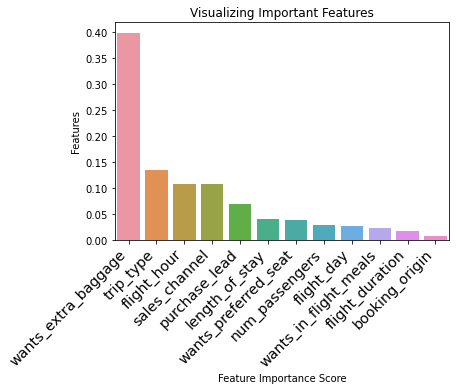

In [35]:
# visualize important featuers

# Creating a bar plot
barplot = sns.barplot(x=feature_importances_df.feature, y=feature_importances_df.importance)

plt.xlabel("Feature Importance Score")
plt.ylabel("Features")
plt.title("Visualizing Important Features")
plt.xticks(
    rotation=45, horizontalalignment="right", fontweight="light", fontsize="x-large"
)
fig = barplot.get_figure()
fig.savefig("out.png", bbox_inches='tight') 
plt.show()
